In [1]:
import numpy as np
import torch
import math
from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 20,
})

In [3]:
# I adapted this implementation from GPytorch library
# https://github.com/cornellius-gp/gpytorch/blob/master/gpytorch/kernels/matern_kernel.py

def matern_kernel(x1, x2, length_scale, nu=1.5, eps=1e-6):
    # Ensure lengthscale is positive to avoid division by zero
    lengthscale = torch.clamp(length_scale, min=eps)

    # Mean subtraction (for input normalization)
    mean_x1 = x1.mean(dim=-2, keepdim=True)
    x1_ = (x1 - mean_x1).div(lengthscale)
    x2_ = (x2 - mean_x1).div(lengthscale)

    # Distance computation
    distance = torch.cdist(x1_, x2_, p=2)

    # Matern kernel computation
    exp_component = torch.exp(-math.sqrt(nu * 2) * distance)

    if nu == 0.5:
        constant_component = 1
    elif nu == 1.5:
        constant_component = (math.sqrt(3) * distance).add(1)
    elif nu == 2.5:
        constant_component = (math.sqrt(5) * distance).add(1).add(5.0 / 3.0 * distance**2)
    return constant_component * exp_component


In [4]:
# GpyTorch library adds jitter in Cholesky implementaiton

def cholesky_with_jitter(K, initial_jitter=1e-8, jitter_max=1e-6, jitter_factor=10):
    jitter = initial_jitter
    jitter_prev = 0
    K_prime = K.clone()

    for i in range(int(math.log10(jitter_max / initial_jitter)) + 1):
        try:
            L, info = torch.linalg.cholesky_ex(K_prime)
            if not torch.any(info):
                return L

            # Handling specific failure cases
            if torch.isnan(K).any():
                raise RuntimeError("NaN values found in the input matrix.")

            # Add jitter only where the Cholesky decomposition failed
            jitter_new = jitter * (jitter_factor ** i)
            diag_add = ((info > 0) * (jitter_new - jitter_prev)).unsqueeze(-1).expand(K.shape)
            K_prime.diagonal(dim1=-1, dim2=-2).add_(diag_add)
            jitter_prev = jitter_new

        except RuntimeError as e:
            if 'not positive definite' not in str(e):
                raise  # Re-raise if the error is not due to positive definiteness

    raise RuntimeError(f"Cholesky decomposition failed. Max jitter tried: {jitter_new}")

In [5]:
class GaussianProcessRegressor(torch.nn.Module):
    def __init__(self, kernel, noise_var, length_scale):
        super(GaussianProcessRegressor, self).__init__()
        self.kernel = kernel
        self.length_scale = torch.nn.Parameter(torch.tensor([length_scale], dtype=torch.float64))
        self.noise_var = torch.nn.Parameter(torch.tensor([noise_var], dtype=torch.float64))

    def forward(self, X_train, Y_train, X_test, use_cholesky=True):
        
        # print('Lengthscale: ',self.length_scale)
        # print('Noise var: ',self.noise_var)
        
        K = self.kernel(X_train, X_train, self.length_scale)
        K = K + torch.exp(self.noise_var) * torch.eye(X_train.size(0), dtype=torch.float64)
        K_s = self.kernel(X_train, X_test, self.length_scale)
        K_ss = self.kernel(X_test, X_test, self.length_scale)

        if use_cholesky:
            # Using Cholesky decomposition for numerical stability - Algorithm 2.1 from Rasmussen
            L = cholesky_with_jitter(K)
            L_inv = torch.linalg.inv(L)
            
            alpha = L_inv.t().matmul(L_inv).matmul(Y_train)

            # Compute the mean of the test points
            mu_s = K_s.t().matmul(alpha)

            # Compute the covariance of the test points
            v = L_inv.matmul(K_s)
            cov_s = K_ss - v.t().matmul(v)

        else:
            # Rasmussen Book
            K_inv = torch.inverse(K)
            alpha = K_inv.matmul(Y_train)
            
            # Compute the mean of the test points
            mu_s = K_s.t().matmul(alpha) # Eq 2.25
            
            # Compute the covariance of the test points
            v = K_inv.matmul(K_s) # Eq 2.26
            cov_s = K_ss - K_s.t().matmul(v)

        return mu_s, cov_s

    def log_marginal_likelihood(self, X_train, Y_train, use_cholesky=True):
        K = self.kernel(X_train, X_train, self.length_scale)
        K = K + torch.exp(self.noise_var) * torch.eye(X_train.size(0), dtype=torch.float64)

        if use_cholesky: # use Cholesky - Algorithm 2.1 from Rasmussen
            
            L = cholesky_with_jitter(K)
            # Ensure Y_train is a column vector
            if Y_train.ndim == 1:
                Y_train = Y_train.unsqueeze(-1)

            # Compute the log marginal likelihood
            L_inv = torch.linalg.inv(L)

            alpha = L_inv.t().matmul(L_inv).matmul(Y_train)
            
            mll = -0.5 * Y_train.t().matmul(alpha)
            mll -= torch.sum(torch.log(torch.diagonal(L)))
            mll -= 0.5 * X_train.size(0) * torch.log(torch.tensor(2 * math.pi, dtype=torch.float64))

        else: # use direct inverse
            
            K_inv = torch.inverse(K)
            alpha = K_inv.matmul(Y_train)

            # Compute the log marginal likelihood from Eq 2.30
            mll = (-0.5 * Y_train.t().matmul(alpha)
                   - 0.5 * torch.log(torch.linalg.det(K))
                   - 0.5 * X_train.size(0) * torch.log(torch.tensor(2 * math.pi, dtype=torch.float64)))

        return mll.squeeze()

In [6]:
# Optimizer:
def optimize_hyperparameters(gp, X_train, Y_train, lr, epochs):

    optimizer = torch.optim.Adam(gp.parameters(), lr=lr)
    l = []
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        
        mll = gp.log_marginal_likelihood(X_train, Y_train)
        loss = -mll
        loss_normalized = loss/Y_train.shape[0]  # Normalize the loss - GPyTorch uses the mean loss across all data points
        l+= [loss_normalized.item()]
        loss_normalized.backward()
        optimizer.step()
        
        print('\n******* Iteration {} *******'.format(epoch+1))
        
        for name, param in gp.named_parameters():
            print(f'Parameter name: {name}, Value: {param.data}')
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss_normalized.item()}')
        
    # Set lengthscale to the optimized value from library 
    # gp.length_scale = torch.nn.Parameter(torch.tensor([2.424041986465454], dtype=torch.float64))
    
    # Set noise to the optimized value from library 
    # gp.noise_var = torch.nn.Parameter(torch.tensor([-3.7276058197021484], dtype=torch.float64))

    print('Optimization complete!')
    plt.plot(l)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [7]:
# Plot the results

def plot_test_results(X,Y,X_t,mu_s_plot,variance_plot):

    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, c='red', label='Training data')
    plt.plot(X_t, mu_s_plot, 'b', label='GP mean')

    plt.fill_between(X_t.flatten(), mu_s_plot - 1.96 * np.sqrt(variance_plot),
                     mu_s_plot + 1.96 * np.sqrt(variance_plot), color='blue', alpha=0.2)  # 95% confidence interval
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [8]:
X = torch.tensor([-4.3, -4.6, -4.8, -3.1, -1.4, -5.6, -6.8, -4.1, -0.5, -2.4, -4.9, -3.6, -8.2, -5.9, -4.0,
                  -8.5, -8.6, -0.6, -7.0, -7.4, -2.6, -2.9, -9.7, -2.2, -8.1, -1.9, -5.3, -6.7, -8.0, -0.4,
                  -3.5, -5.8, -2.3, -1.5, -9.8, 10.0, 10.2, 10.1, 10.6, 9.5, -6.8, -7.0, -6.8, -6.9, -6.8],
                 dtype=torch.float64).reshape((-1, 1))

Y = torch.tensor([-0.6, 0.0, 0.2, -1.8, -1.7, 1.3, 1.8, -0.6, -0.6, -2.2, 0.3, -1.2, 1.5, 1.5, -1.1, 1.1, 1.4,
                  -0.7, 2.1, 1.8, -1.8, -1.9, -0.1, -2.1, 1.6, -1.9, 0.5, 1.5, 1.3, -0.7, -1.3, 1.6, -2.2, -1.6,
                  -0.3, 0.7, 1.1, 0.9, 1.0, 0.6, 2.0, 1.9, 1.9, 2.1, 1.9],
                 dtype=torch.float64).reshape((-1, 1))

X_t = torch.linspace(float(min(X).item()-5), float(max(X).item()+5), 100, dtype=torch.float64).unsqueeze(-1)

In [9]:
kern = matern_kernel

num_ites = 200
learning_rate = 0.11 # same as the GpyTorch library

initial_noise = -1e-1
length_scale = 1e-1


******* Iteration 1 *******
Parameter name: length_scale, Value: tensor([0.2100], dtype=torch.float64)
Parameter name: noise_var, Value: tensor([-0.2100], dtype=torch.float64)
Epoch 1/200, Loss: 1.5745952527845783

******* Iteration 2 *******
Parameter name: length_scale, Value: tensor([0.3154], dtype=torch.float64)
Parameter name: noise_var, Value: tensor([-0.3185], dtype=torch.float64)
Epoch 2/200, Loss: 1.4239349884401955

******* Iteration 3 *******
Parameter name: length_scale, Value: tensor([0.4160], dtype=torch.float64)
Parameter name: noise_var, Value: tensor([-0.4275], dtype=torch.float64)
Epoch 3/200, Loss: 1.316173258516795

******* Iteration 4 *******
Parameter name: length_scale, Value: tensor([0.5117], dtype=torch.float64)
Parameter name: noise_var, Value: tensor([-0.5371], dtype=torch.float64)
Epoch 4/200, Loss: 1.229698644132581

******* Iteration 5 *******
Parameter name: length_scale, Value: tensor([0.6029], dtype=torch.float64)
Parameter name: noise_var, Value: tens

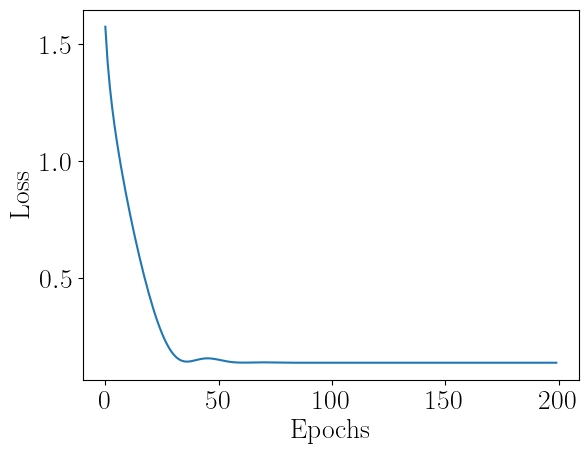

In [10]:
# Initialize the GP model with the new settings for float64 precision
gp = GaussianProcessRegressor(kernel=kern, noise_var=initial_noise, length_scale=length_scale)

# Run the optimization with the new settings
optimize_hyperparameters(gp, X, Y, lr=learning_rate, epochs=num_ites)

# Output the final length_scale and variance parameters after optimization
length_scale_optimized = gp.length_scale.item()
noise_var_optimized = gp.noise_var.item()


# Return the optimized hyperparameters
length_scale_optimized, noise_var_optimized

with torch.no_grad():
    mu_s, cov_s = gp(X, Y, X_t)

# Convert predictions to numpy for plotting or other purposes
mu_s = mu_s.numpy().flatten()
cov_s = cov_s.numpy()
variance = cov_s.diagonal()

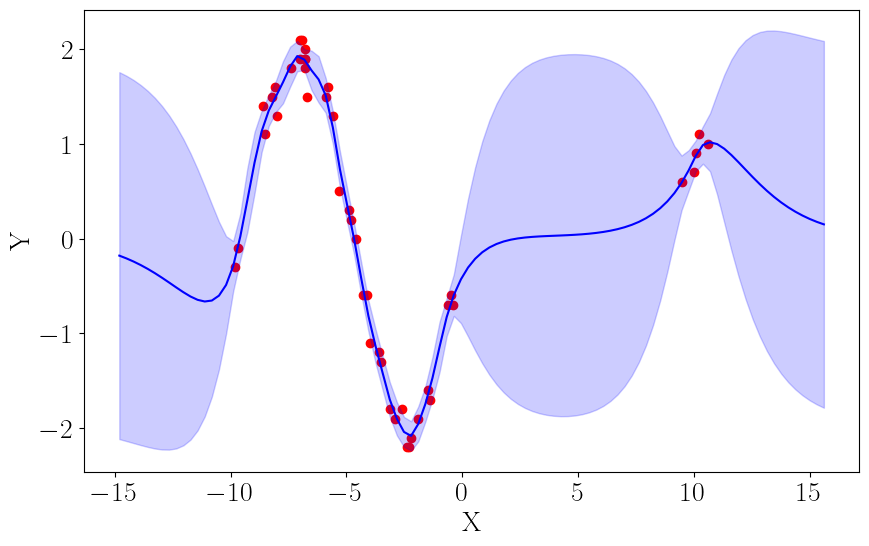

Kernel parameters: lenghtscale = 2.508824898321753, noise_var= -3.735409224505387, exp_noise_var= 0.023863403580808424


In [11]:
plot_test_results(X,Y,X_t,mu_s,variance)

print(f"Kernel parameters: lenghtscale = {length_scale_optimized}, noise_var= {noise_var_optimized}, exp_noise_var= {np.exp(noise_var_optimized)}")

In [12]:
manual_mu = mu_s
manual_mu

array([-0.17925622, -0.20849012, -0.24153482, -0.2785599 , -0.31960256,
       -0.36449558, -0.41276876, -0.46351508, -0.51521069, -0.56547413,
       -0.61074624, -0.64586682, -0.66351688, -0.65348686, -0.60171959,
       -0.48906242, -0.28964456,  0.02286069,  0.40983393,  0.80295776,
        1.13385023,  1.35269823,  1.50126013,  1.65206393,  1.81596594,
        1.92795071,  1.89032403,  1.77780043,  1.68197901,  1.51277242,
        1.17542161,  0.732259  ,  0.35936944, -0.00760429, -0.42308426,
       -0.81606096, -1.13323576, -1.41795921, -1.69761954, -1.90187546,
       -2.04109366, -2.0826275 , -1.95757906, -1.74655798, -1.47193366,
       -1.14241383, -0.82778648, -0.59568959, -0.4295949 , -0.30507331,
       -0.21226902, -0.14356702, -0.09309488, -0.05633277, -0.02980834,
       -0.01085827,  0.00255804,  0.01200403,  0.0186797 ,  0.02351071,
        0.02721825,  0.03037432,  0.03344577,  0.03682999,  0.04088454,
        0.04595252,  0.05238525,  0.06056366,  0.0709196 ,  0.08

In [13]:
np.save("manual_mu",mu_s)